In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import numpy as np
from collections import Counter
import pickle
import random

from node2vec import Node2Vec
from sklearn.manifold import TSNE
import umap

In [2]:
with open("G_bot.pkl", "rb") as f:
    G_bot = pickle.load(f)
with open("G_ide.pkl", "rb") as f:
    G_ide = pickle.load(f)

In [23]:
with open("G_ide_5s.pkl", "rb") as f:
    G_ide_5s = pickle.load(f)

In [47]:
with open("G_ide_url_30s.pkl", "rb") as f:
    G_ide_url_30s = pickle.load(f)

In [3]:
# giant component of ide network
with open("G_ide_gc.pkl", "rb") as f:
    G_ide_gc = pickle.load(f)
with open("G_bot_gc.pkl", "rb") as f:
    G_bot_gc = pickle.load(f)
# communities of giant component of bot network
with open("G_bot_gc_comms.pkl", "rb") as f:
    bot_comms = pickle.load(f)
# communities of complete bot network
with open("G_bot_full_comms.pkl", "rb") as f:
    bot_comms_all = pickle.load(f)
# communities of giant component of ide network
with open("G_ide_gc_comms.pkl", "rb") as f:
    ide_comms = pickle.load(f)

In [34]:
def plot_network(G, title="Network", node_color=None):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color, cmap="tab20")
    nx.draw_networkx_edges(G, pos, alpha=0.25)
    plt.title(title)
    plt.axis("off")
    plt.show()


def to_igraph(G):
    """networkx graph → igraph graph"""
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    g = ig.Graph(edges=edges, directed=False)
    g.vs["name"] = list(mapping.keys())
    return g

## 1. Visualisation

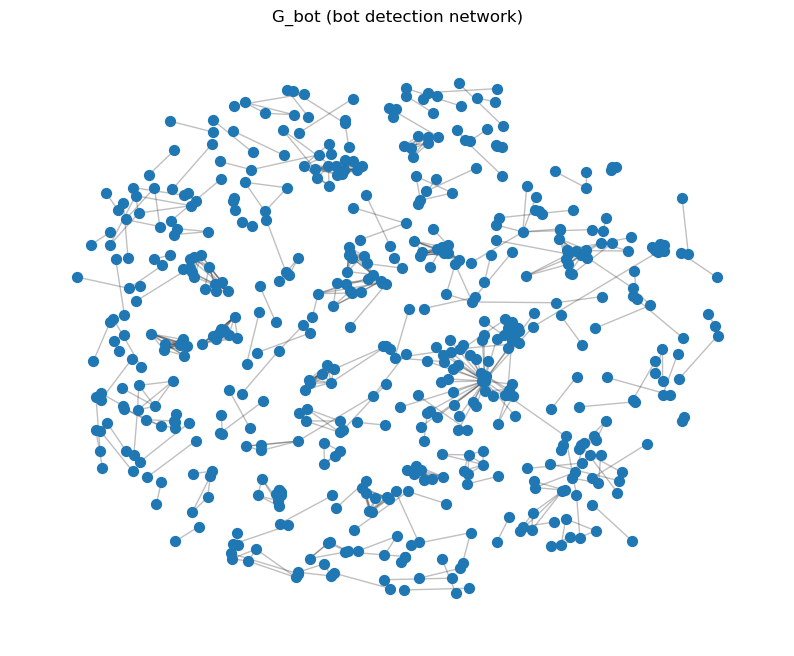

In [53]:
plot_network(G_bot, "G_bot (bot detection network)")
# plot_network(G_ide, "G_ide (ideology/topic network)") # too big

## 2. Compute connected components

In [26]:
def print_components(G, name="Graph"):
    comps = list(nx.connected_components(G))
    comps_sizes = [len(c) for c in comps]
    print(f"\n===== {name}: Connected Components =====")
    print(f"Number of components: {len(comps)}")
    print(f"Size distribution: {Counter(comps_sizes)}")



In [27]:
print_components(G_bot, "G_bot")
print_components(G_ide, "G_ide")


===== G_bot: Connected Components =====
Number of components: 163
Size distribution: Counter({2: 102, 3: 26, 6: 8, 4: 7, 5: 5, 9: 4, 7: 4, 10: 2, 8: 1, 51: 1, 13: 1, 12: 1, 16: 1})

===== G_ide: Connected Components =====
Number of components: 45
Size distribution: Counter({2: 32, 3: 7, 4: 2, 190352: 1, 17: 1, 5: 1, 9: 1})


In [28]:
print_components(G_ide_5s, "G_ide")


===== G_ide: Connected Components =====
Number of components: 1180
Size distribution: Counter({2: 905, 3: 174, 4: 50, 5: 21, 6: 9, 7: 7, 13: 4, 9: 3, 8: 2, 21337: 1, 15: 1, 31: 1, 14: 1, 16: 1})


In [48]:
print_components(G_ide_url_30s, "G_ide_url_30s")


===== G_ide_url_30s: Connected Components =====
Number of components: 1114
Size distribution: Counter({2: 721, 3: 194, 4: 76, 5: 35, 6: 22, 7: 21, 8: 12, 9: 5, 10: 4, 11: 3, 13: 3, 12: 2, 17: 2, 16: 2, 1202: 1, 20: 1, 18: 1, 26: 1, 30: 1, 42: 1, 21: 1, 14: 1, 32: 1, 23: 1, 36: 1, 70: 1})


## 3. Select giant component

In [29]:
def get_giant_component(G):
    giant = max(nx.connected_components(G), key=len)
    return G.subgraph(giant).copy()

In [ ]:
G_bot_gc = get_giant_component(G_bot)
G_ide_gc = get_giant_component(G_ide)

print(f"G_bot giant component size: {G_bot_gc.number_of_nodes()}")
print(f"G_ide giant component size: {G_ide_gc.number_of_nodes()}")

G_bot giant component size: 51
G_ide giant component size: 190352


In [31]:
G_ide_5s_gc = get_giant_component(G_ide_5s)

print(f"G_ide_5s giant component size: {G_ide_5s_gc.number_of_nodes()}")

G_ide_5s giant component size: 21337


In [49]:
G_ide_url_30s_gc = get_giant_component(G_ide_url_30s)

print(f"G_ide_url_30s giant component size: {G_ide_url_30s_gc.number_of_nodes()}")

G_ide_url_30s giant component size: 1202


## 4. Use Louvain method to detect communities

In [43]:
def detect_communities(G, name="Graph",resolution=1):
    g_ig = to_igraph(G)
    communities = g_ig.community_multilevel(resolution=resolution)  # Louvain
    membership = communities.membership

    print(f"\n===== {name}: Louvain Communities =====")
    print(f"Number of communities: {len(communities)}")
    sizes = Counter(membership)
    print(f"Community size distribution: {sizes}")

    # 可视化 - 节点按社区着色
    # node_colors = membership
    # plot_network(G, f"{name}: Communities (Louvain)", node_color=node_colors)

    return membership, communities

In [ ]:
bot_membership, bot_comms = detect_communities(G_bot_gc, "G_bot GC")
ide_membership, ide_comms = detect_communities(G_ide_gc, "G_ide GC")


===== G_bot GC: Louvain Communities =====
Number of communities: 2
Community size distribution: Counter({0: 36, 1: 15})

===== G_ide GC: Louvain Communities =====
Number of communities: 17
Community size distribution: Counter({1: 66933, 7: 22597, 2: 20123, 3: 17212, 11: 10189, 4: 10038, 5: 8634, 0: 7069, 6: 6764, 9: 5592, 10: 5559, 8: 4397, 13: 2941, 14: 1252, 12: 1029, 16: 14, 15: 9})


In [45]:
ide_5s_membership, ide_5s_comms = detect_communities(G_ide_5s_gc, "G_ide_5s GC",0.5)


===== G_ide_5s GC: Louvain Communities =====
Number of communities: 78
Community size distribution: Counter({0: 7644, 10: 2306, 8: 1600, 14: 1028, 20: 985, 22: 630, 5: 594, 16: 584, 15: 551, 24: 539, 21: 420, 19: 408, 25: 379, 1: 342, 27: 339, 11: 286, 37: 273, 41: 269, 23: 256, 26: 255, 13: 238, 2: 230, 9: 226, 7: 217, 12: 151, 29: 100, 28: 67, 3: 37, 34: 31, 51: 24, 53: 16, 44: 15, 6: 12, 46: 12, 56: 11, 63: 11, 67: 11, 59: 10, 65: 10, 77: 9, 17: 8, 40: 8, 55: 8, 18: 7, 32: 7, 52: 7, 57: 7, 61: 7, 66: 7, 74: 7, 33: 6, 35: 6, 38: 6, 71: 6, 4: 5, 36: 5, 39: 5, 47: 5, 48: 5, 49: 5, 54: 5, 58: 5, 60: 5, 62: 5, 64: 5, 68: 5, 69: 5, 70: 5, 72: 5, 73: 5, 75: 5, 76: 5, 30: 4, 31: 4, 42: 4, 43: 4, 45: 4, 50: 4})


In [17]:
bot_membership_all, bot_comms_all = detect_communities(G_bot, "G_bot")


===== G_bot: Louvain Communities =====
Number of communities: 164
Community size distribution: Counter({35: 36, 143: 16, 72: 15, 75: 13, 100: 12, 3: 10, 13: 10, 6: 9, 31: 9, 80: 9, 158: 9, 14: 8, 7: 7, 34: 7, 99: 7, 109: 7, 5: 6, 23: 6, 52: 6, 64: 6, 90: 6, 133: 6, 136: 6, 162: 6, 11: 5, 19: 5, 22: 5, 74: 5, 106: 5, 1: 4, 48: 4, 82: 4, 84: 4, 117: 4, 130: 4, 135: 4, 4: 3, 8: 3, 9: 3, 10: 3, 12: 3, 17: 3, 29: 3, 40: 3, 47: 3, 51: 3, 53: 3, 55: 3, 60: 3, 67: 3, 70: 3, 73: 3, 76: 3, 89: 3, 91: 3, 107: 3, 108: 3, 110: 3, 116: 3, 119: 3, 131: 3, 160: 3, 0: 2, 2: 2, 15: 2, 16: 2, 18: 2, 20: 2, 21: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 30: 2, 32: 2, 33: 2, 36: 2, 37: 2, 38: 2, 39: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 49: 2, 50: 2, 54: 2, 56: 2, 57: 2, 58: 2, 59: 2, 61: 2, 62: 2, 63: 2, 65: 2, 66: 2, 68: 2, 69: 2, 71: 2, 77: 2, 78: 2, 79: 2, 81: 2, 83: 2, 85: 2, 86: 2, 87: 2, 88: 2, 92: 2, 93: 2, 94: 2, 95: 2, 96: 2, 97: 2, 98: 2, 101: 2, 102: 2, 103: 2, 104: 2, 105: 2, 111: 2, 112: 2

In [50]:
G_ide_url_30s_gc_membership, G_ide_url_30s_gc_comms = detect_communities(G_ide_url_30s_gc, "G_ide_url_30s_gc GC")


===== G_ide_url_30s_gc GC: Louvain Communities =====
Number of communities: 31
Community size distribution: Counter({3: 160, 6: 90, 17: 73, 23: 73, 10: 55, 21: 53, 5: 52, 2: 51, 25: 49, 0: 46, 24: 45, 12: 40, 29: 39, 14: 38, 13: 37, 16: 30, 4: 29, 20: 27, 15: 25, 1: 21, 18: 21, 22: 20, 9: 19, 7: 18, 27: 17, 19: 15, 28: 15, 11: 14, 26: 13, 30: 10, 8: 7})


In [ ]:
# G_ide_url_30s_gc_membership, G_ide_url_30s_gc_comms = detect_communities(G_ide_url_30s_gc, "G_ide_url_30s_gc GC", resolution=0.5)

## 5. Visualisation for communities

In [36]:
def plot_communities(G, communities, title="Network"):
    # 导入所需的库
    import matplotlib.pyplot as plt
    import networkx as nx
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)

    # --- 关键修改：提取 igraph 社区成员列表 ---
    try:
        # 假设 communities 是 igraph 的 VertexClustering 对象
        node_community_ids = communities.membership
        print("INFO: Using .membership list from igraph object for coloring.")
    except AttributeError:
        # 如果传入的不是 igraph 对象，则假设是之前的社区ID字典，
        # 并尝试映射回 networkx 节点的顺序
        print("WARNING: 'communities' does not have a .membership attribute. Trying dictionary mapping.")
        node_community_ids = [communities.get(node) for node in G.nodes()]
    
    # 使用社区ID列表和 Colormap (如 "tab20") 来着色
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=50,
        node_color=node_community_ids,  # 传入社区ID列表
        cmap="tab20"                   # 使用 "tab20" Colormap
    )
    
    nx.draw_networkx_edges(G, pos, alpha=0.25)
    
    plt.title(title)
    plt.axis("off")
    plt.show()


INFO: Using .membership list from igraph object for coloring.


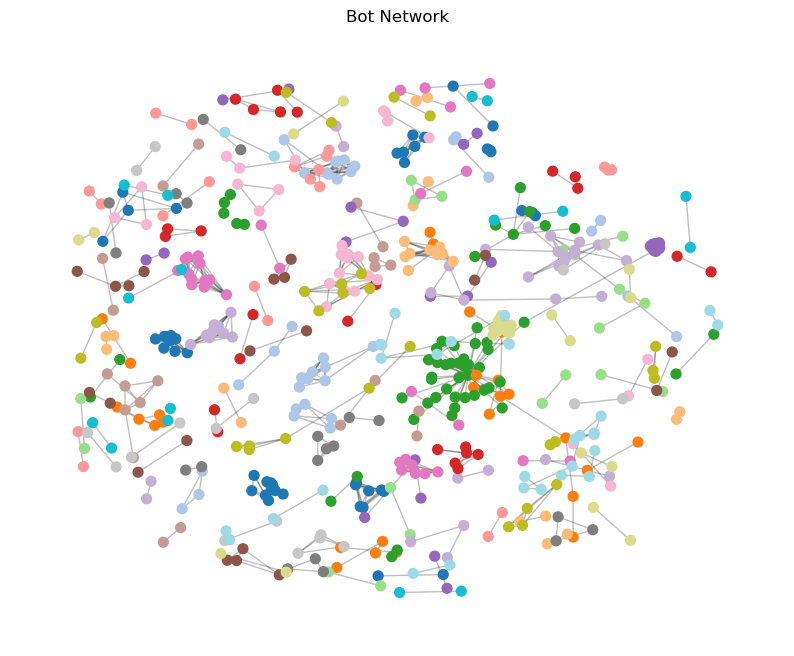

In [ ]:
plot_communities(G_bot, bot_comms_all, title="Bot Network")

In [21]:
G_bot.number_of_nodes()

567

In [41]:
def plot_communities_without_edges(G, communities, title="Network"):
    # 导入所需的库
    import matplotlib.pyplot as plt
    import networkx as nx
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)

    # --- 关键修改：提取 igraph 社区成员列表 ---
    try:
        # 假设 communities 是 igraph 的 VertexClustering 对象
        node_community_ids = communities.membership
        print("INFO: Using .membership list from igraph object for coloring.")
    except AttributeError:
        # 如果传入的不是 igraph 对象，则假设是之前的社区ID字典，
        # 并尝试映射回 networkx 节点的顺序
        print("WARNING: 'communities' does not have a .membership attribute. Trying dictionary mapping.")
        node_community_ids = [communities.get(node) for node in G.nodes()]
    
    # 使用社区ID列表和 Colormap (如 "tab20") 来着色
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=15,
        node_color=node_community_ids,  # 传入社区ID列表
        cmap="tab20",                   # 使用 "tab20" Colormap
        alpha=0.7
    )
    
    # nx.draw_networkx_edges(G, pos, alpha=0.25)
    
    plt.title(title)
    plt.axis("off")
    plt.show()

INFO: Using .membership list from igraph object for coloring.


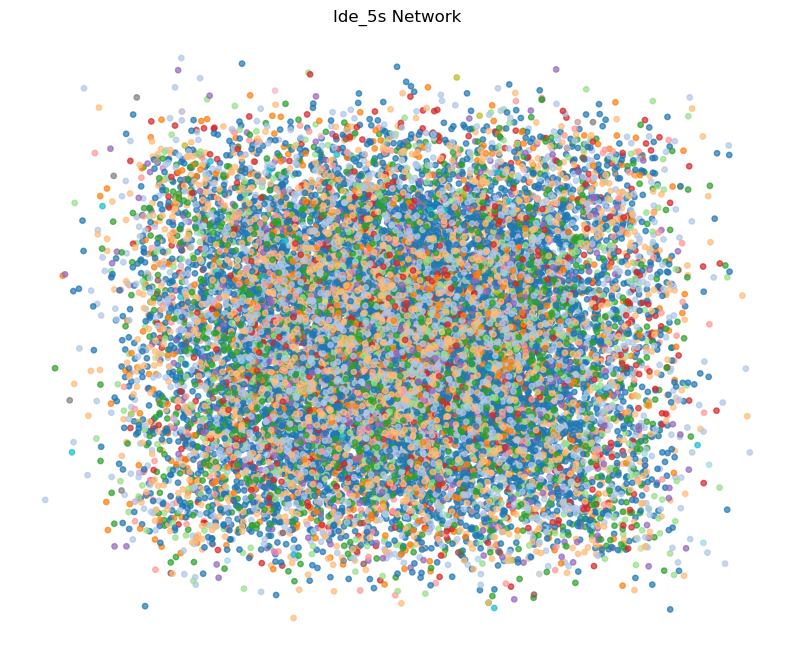

In [ ]:
# resolution=1 default
plot_communities_without_edges(G_ide_5s_gc, ide_5s_comms, title="Ide_5s Network")

INFO: Using .membership list from igraph object for coloring.


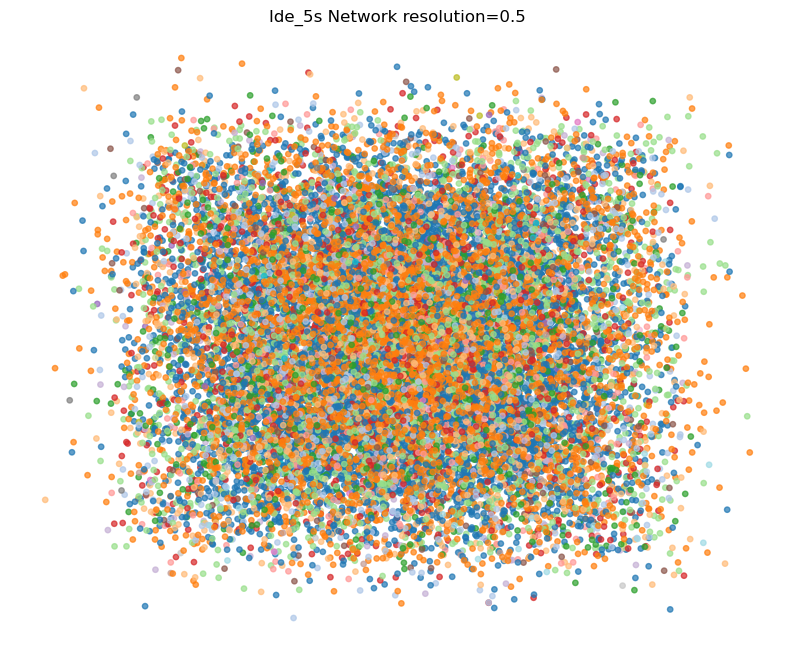

In [46]:
# resolution=0.5 default
plot_communities_without_edges(G_ide_5s_gc, ide_5s_comms, title="Ide_5s Network resolution=0.5")

INFO: Using .membership list from igraph object for coloring.


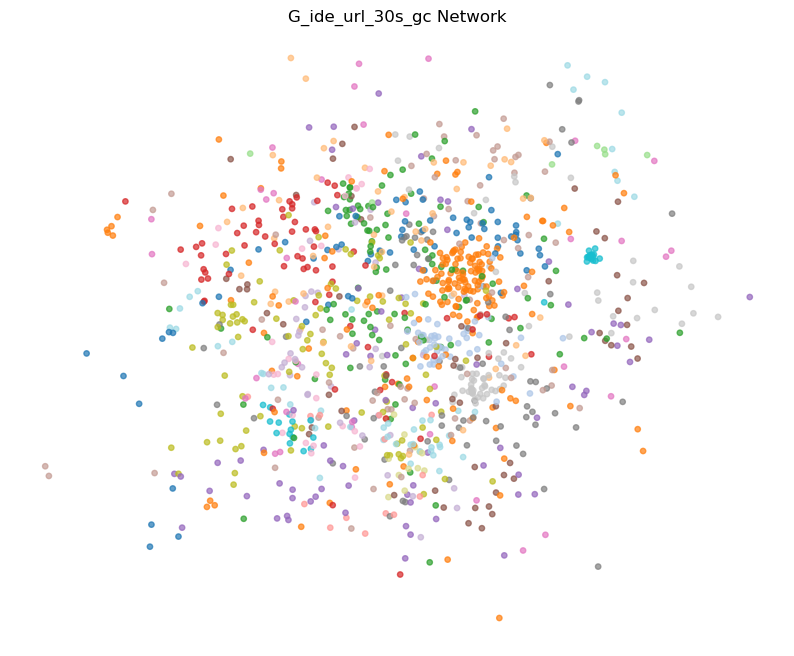

In [51]:
# resolution=1 default url_30s
plot_communities_without_edges(G_ide_url_30s_gc, G_ide_url_30s_gc_comms, title="G_ide_url_30s_gc Network")

## Save info for task 3

In [59]:
# giant component of ide network
with open("G_ide_gc.pkl", "wb") as f:
    pickle.dump(G_ide_gc, f)
with open("G_bot_gc.pkl", "wb") as f:
    pickle.dump(G_bot_gc, f)

In [48]:
# communities of giant component of bot network
with open("G_bot_gc_comms.pkl", "wb") as f:
    pickle.dump(bot_comms, f)
# communities of complete bot network
with open("G_bot_full_comms.pkl", "wb") as f:
    pickle.dump(bot_comms_all, f)
# communities of giant component of ide network
with open("G_ide_gc_comms.pkl", "wb") as f:
    pickle.dump(ide_comms, f)

## Examples for Task 3

In [50]:
with open("G_ide_gc_comms.pkl", "rb") as f:
    communities = pickle.load(f)

In [51]:
k = 5   # 选择第 0 个社区，你可以改成其他编号

# 社区中的节点索引
community_nodes = communities[k]  

# 将 igraph 节点索引转为原始账户 ID
community_users = [node for node in community_nodes]

print("Selected community:", k)
print("Number of users:", len(community_users))
print("User list example:", community_users[:20])


Selected community: 5
Number of users: 8634
User list example: [17, 37, 38, 85, 252, 288, 335, 338, 349, 350, 412, 416, 424, 484, 501, 515, 536, 566, 613, 652]
